In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

In [2]:
df = pd.read_csv("Company Stock and Investment.csv")
df.head()

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [3]:
df.shape

(1984, 5)

In [4]:
# We can dropOil, Comp Stock and Other invesments
df.drop(["Oil Investments", "Comp Stock", "Other sharesInvestments"], axis=1, inplace=True)
df.head()

,Date,Gold Investments
0,31-12-2009,0.000150
1,04-01-2010,0.001097
2,05-01-2010,0.001560
3,06-01-2010,0.006009
4,07-01-2010,0.000221


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1984 non-null   object 
 1   Gold Investments  1984 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.1+ KB


In [6]:
# Convert Date column from object to datetime
df.Date = pd.to_datetime(df.Date)
df.head()

,Date,Gold Investments
0,2009-12-31,0.000150
1,2010-04-01,0.001097
2,2010-05-01,0.001560
3,2010-06-01,0.006009
4,2010-07-01,0.000221


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1984 non-null   datetime64[ns]
 1   Gold Investments  1984 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.1 KB


In [8]:
df.describe()

,Gold Investments
count,1984.000000
mean,-0.020152
std,0.140965
min,-1.000000
25%,-0.005881
50%,0.000000
75%,0.005454
max,0.049577


In [9]:
df.isna().sum()

Date                0
Gold Investments    0
dtype: int64

In [10]:
df.set_index('Date', inplace=True)

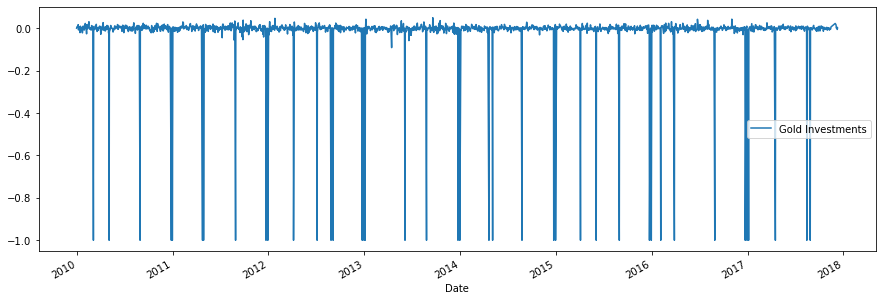

In [11]:
df.plot(figsize=(15, 5))

In [13]:
def adf_test_stat(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','Lags Used','Number of Observations']
    for i in range(len(labels)):
        print(labels[i],' = ', result[i])
    if result[1]>0.05:
        print('The',labels[1],' is higher than 0.05 and it strongly support Null hypothesis that the data is non stationary')
    else:
         print('\nThe',labels[1],' is less than 0.05 and it strongly rejects Null hypothesis and hold the alternate hypothesis which says that the data is stationary')

In [14]:
adf_test_stat(df['Gold Investments'])

ADF Test Statistic  =  -15.906853851668977
p-value  =  8.208405770370657e-29
Lags Used  =  7
Number of Observations  =  1976

The p-value  is less than 0.05 and it strongly rejects Null hypothesis and hold the alternate hypothesis which says that the data is stationary


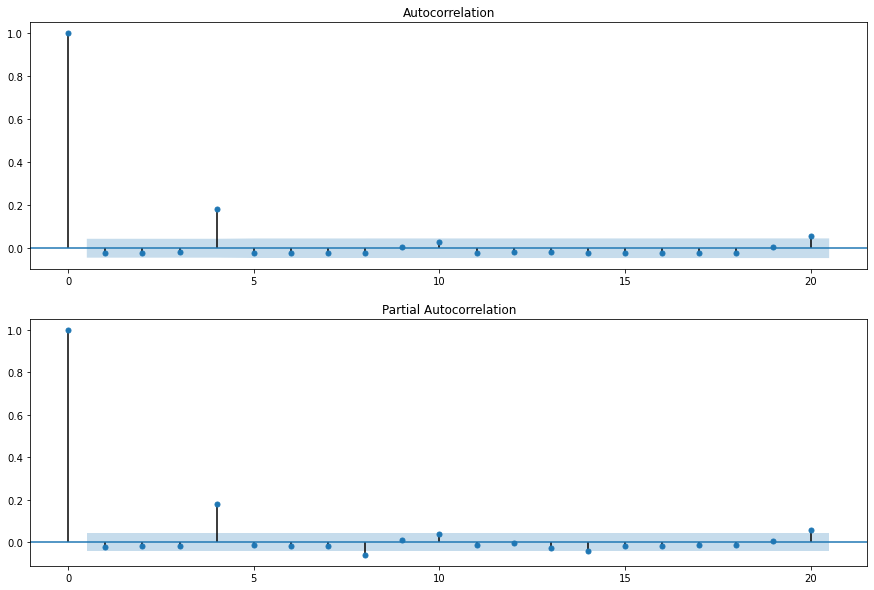

In [16]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Gold Investments'],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Gold Investments'],lags=20,ax=ax2)

In [17]:
size=int(len(df)*0.75)
train_data, test_data = df[0:size], df[size:]
model = ARIMA(train_data,order=(1,1,1))
results=model.fit()

In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.Gold Investments   No. Observations:                 1487
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 824.413
Method:                       css-mle   S.D. of innovations              0.139
Date:                Fri, 06 Nov 2020   AIC                          -1640.827
Time:                        19:14:34   BIC                          -1619.608
Sample:                             1   HQIC                         -1632.919
                                                                              
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -5.113e-07   8.19e-06     -0.062      0.950   -1.66e-05    1.55e-05
ar.L1.D.Gold Investments    -0.0222      0.026     -0.856      0.392      -0.073       0.029
ma.L1.D.Gold Investments    -0.9999      0.002   -559.138      0.000      -1.003      -0.996
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -45.0615           +0.0000j           45.0615            0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

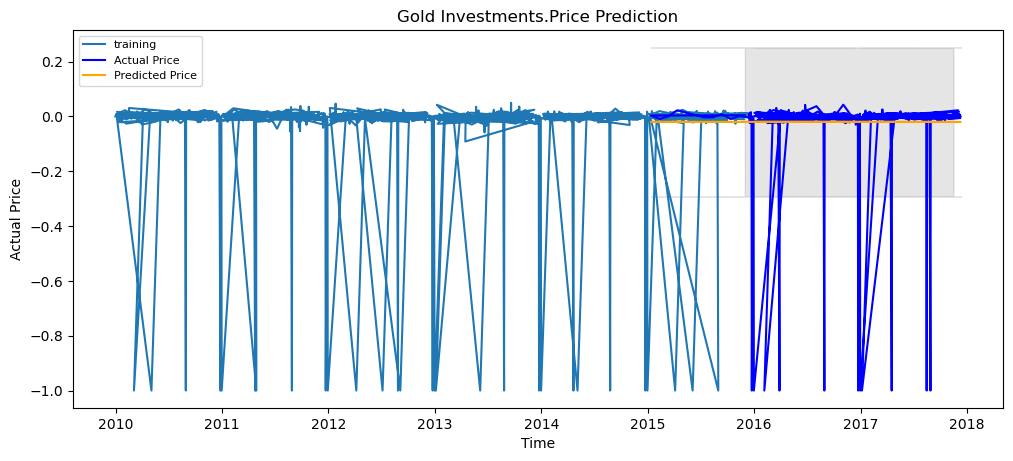

In [19]:
#Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.
fc, se, conf = results.forecast(496, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Price')
plt.plot(fc_series, color = 'orange',label='Predicted Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Gold Investments.Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [20]:
# Forecasting future data
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,1508)]
future_datest_df=pd.DataFrame(index=future_dates[1:], columns=df.columns)

future_datest_df.tail()

,Gold Investments
2021-12-27,NaN
2021-12-28,NaN
2021-12-29,NaN
2021-12-30,NaN
2021-12-31,NaN


In [21]:
fc1, se1, conf1 = results.forecast(1507, alpha=0.05)  # 95% confidence
fc1_series = pd.Series(fc1, index=future_datest_df.index)
fc1_series

2017-11-16   -0.020197
2017-11-17   -0.019970
2017-11-18   -0.019976
2017-11-19   -0.019976
2017-11-20   -0.019977
                ...   
2021-12-27   -0.020742
2021-12-28   -0.020743
2021-12-29   -0.020743
2021-12-30   -0.020744
2021-12-31   -0.020744
Length: 1507, dtype: float64

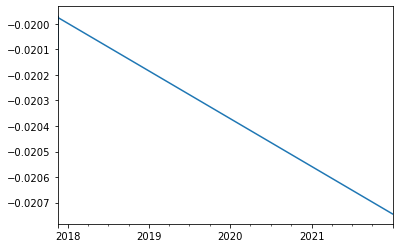

In [22]:
fc1_series.plot()